# Trucation of the Pauli Weight during propagation

In [76]:
import pennylane as qml # To define the circuit
from pprop.propagator import Propagator # For Pauli Propagation
from pprop.utils import parse_terms_numba

import numpy as np
import tqdm
import copy

In [35]:
# Definition of a very large but simulable circuit
def ansatz(params, num_qubits):
    params_index = 0
    for q in range(num_qubits):
        qml.Hadamard(wires=q)
        qml.RY(params[params_index], wires=q)
        params_index += 1

    for _ in range(2):
        for q_control, q_target in zip(range(0, num_qubits, 2), range(1, num_qubits, 2)):
            qml.CNOT(wires=[q_control, q_target])

        qml.Barrier()

        for q in range(num_qubits):
            qml.RY(params[params_index], wires=q)
            params_index += 1

        for q_control, q_target in zip(range(1, num_qubits, 2), range(2, num_qubits, 2)):
            qml.CNOT(wires=[q_control, q_target])

        qml.Barrier()

        for q in range(num_qubits):
            qml.RY(params[params_index], wires=q)
            params_index += 1


    return qml.expval(sum(qml.PauliZ(i) for i in range(num_qubits)))


In [36]:
prop = Propagator(lambda params: ansatz(params, num_qubits=4), k1=None, k2=None)
prop

Propagator
  Number of qubits : 4
  Trainable parameters : 20
  Cutoff 1: None | Cutoff 2: None
  Observables [Z(0) + Z(1) + Z(2) + Z(3)]
0: ──H──RY─╭●──||──RY─────||──RY─╭●──||──RY─────||──RY─┤ ╭<𝓗>
1: ──H──RY─╰X──||──RY─╭●──||──RY─╰X──||──RY─╭●──||──RY─┤ ├<𝓗>
2: ──H──RY─╭●──||──RY─╰X──||──RY─╭●──||──RY─╰X──||──RY─┤ ├<𝓗>
3: ──H──RY─╰X──||──RY─────||──RY─╰X──||──RY─────||──RY─┤ ╰<𝓗>

In [96]:
def reduce_propagated(propagated, k1, k2):
    new_propagated = {}
    for base, coeffs in propagated.items():
        # Cut on Pauli Weight:
        if k1 is None or len(base[0]) <= k1:
            # Cut on Frequency:
            new_coeffs = []
            for c in coeffs:
                if k2 is None or len(c[1:]) <= k2:
                    new_coeffs.append(c)

            if new_coeffs:
                new_propagated[base] = new_coeffs
                
    return new_propagated

def reduce_propagator(propagator, k1, k2):
    _propagated_reduced = [reduce_propagated(p, k1, k2) for p in propagator._propagated]
    propagator_reduced = copy.deepcopy(propagator)
    propagator_reduced.k1 = k1
    propagator_reduced.k2 = k2
    propagator_reduced._propagated = _propagated_reduced
    propagator_reduced._parsed = [parse_terms_numba(d) for d in propagator_reduced._propagated]
    
    return propagator_reduced
    
def evaulate_accuracy(propagator, k1, k2, num_samples: int = 100):
    prop_reduced = reduce_propagator(propagator, k1, k2)
    qcircuit = qml.QNode(lambda params: ansatz(params, num_qubits=propagator.num_qubits), qml.device('default.qubit', wires=propagator.num_qubits))
    params_list = 4*np.pi*np.random.rand(num_samples, propagator.num_params) - 2 * np.pi

    true_list = [qcircuit(params) for params in params_list]
        
    errs = []
    for i, params in enumerate(params_list):
        errs.append(prop_reduced.eval(params) - true_list[i])
        
    return np.mean(np.square(errs)), np.std(np.square(errs))

In [97]:
prop = Propagator(lambda params: ansatz(params, num_qubits=16), k1=None, k2=None)
prop.propagate(bar=False)
result_dict = {}
klist = np.arange(2, prop.num_qubits + 1, 1)
progress = tqdm.tqdm(range(len(klist) ** 2), desc="Evaluating accuracy")
for k1 in klist:
    for k2 in klist:
        mean, std = evaulate_accuracy(prop, k1 = k1, k2 = k2)
        result_dict[(k1, k2)] = {'mean': mean, 'std': std}
        progress.update(1)

Evaluating accuracy:   0%|          | 0/225 [01:10<?, ?it/s]


In [102]:
import pickle

with open("result_dict.pkl", "wb") as f:
    pickle.dump(result_dict, f)

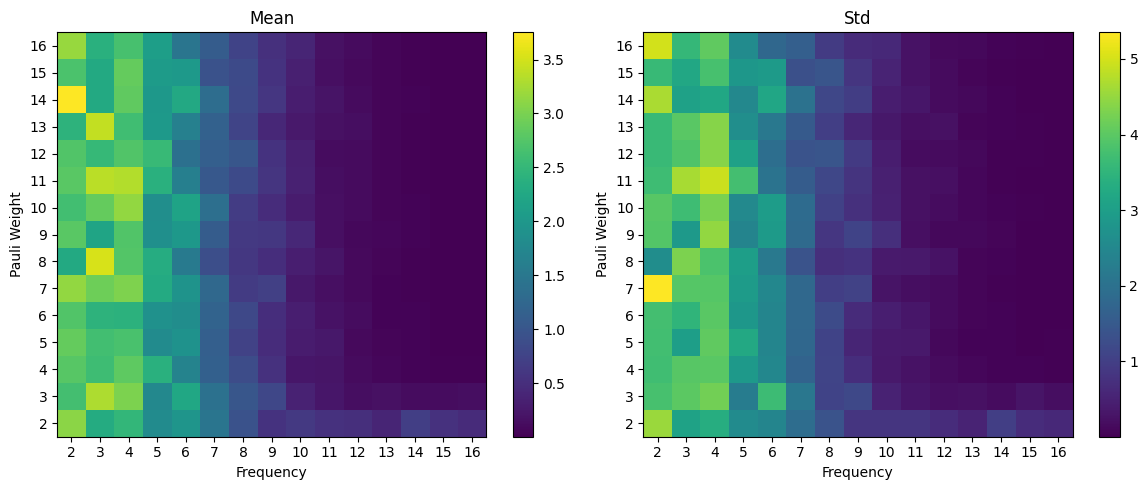

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose your keys
k1_values = sorted(set(k for k, _ in result_dict.keys()))
k2_values = sorted(set(k for _, k in result_dict.keys()))

# Prepare 2D arrays for mean and std
mean_array = np.zeros((len(k1_values), len(k2_values)))
std_array  = np.zeros((len(k1_values), len(k2_values)))

for i, k1 in enumerate(k1_values):
    for j, k2 in enumerate(k2_values):
        mean_array[i, j] = result_dict[(k1, k2)]['mean']
        std_array[i, j]  = result_dict[(k1, k2)]['std']

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(mean_array, origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title('Mean')
axes[0].set_xticks(range(len(k2_values)))
axes[0].set_yticks(range(len(k1_values)))
axes[0].set_xticklabels(k2_values)
axes[0].set_yticklabels(k1_values)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Pauli Weight')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(std_array, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title('Std')
axes[1].set_xticks(range(len(k2_values)))
axes[1].set_yticks(range(len(k1_values)))
axes[1].set_xticklabels(k2_values)
axes[1].set_yticklabels(k1_values)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Pauli Weight')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()